In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
import xgboost
from sklearn import svm
from sklearn import metrics
pd.set_option('max_columns', 120)
pd.set_option('max_colwidth', 5000)
import warnings

%matplotlib inline

# inspired by 
# https://github.com/mbadi/Stop_and_Frisk_Classification-/blob/master/NYPD_Stop-and-Frisk.ipynb
# https://github.com/alexamanpreet/Machine-Learning-using-DNN-on-NYPD-s-Stop-and-Frisk/blob/master/Machine%20Learning%20using%20DNN%20on%20NYPD's%20%20Stop-and-Frisk.ipynb

### 

- pct PRECINCT OF STOP (FROM 1 TO 123)
- inout		WAS STOP INSIDE OR OUTSIDE
- perobs		PERIOD OF OBSERVATION (MMM)
- perstop		PERIOD OF STOP (MMM)
- explnstp		DID OFFICER EXPLAIN REASON FOR STOP ?
- arstmade		WAS AN ARREST MADE ?
- sumissue		WAS A SUMMONS ISSUED ?
- offunif		WAS OFFICER IN UNIFORM ?
- frisked		WAS SUSPECT FRISKED ?
- searched		WAS SUSPECT SEARCHED ?
- contrabn		WAS CONTRABAND FOUND ON SUSPECT ?
- pistol		WAS A PISTOL FOUND ON SUSPECT ?
- rf_attir		REASON FOR FRISK - INAPPROPRIATE ATTIRE FOR SEASON
- sex		SUSPECT'S SEX
- race		SUSPECT'S RACE
- age		SUSPECT'S AGE

##
- A - ASIAN/PACIFIC ISLANDER
- B - BLACK
- I - AMERICAN INDIAN/ALASKAN NATIVE
- P - BLACK-HISPANIC
- Q - WHITE-HISPANIC
- W - WHITE
- U - UNKNOWN
- Z - OTHER

In [2]:
## READ DATA 
df = pd.read_csv('../data/sqf_2013_2016.csv')
df.shape

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,8,10,18,19,41,73,74,82,83,84,85,86,103,110,111) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(272606, 112)

##  Preprocessing 

In [3]:
## Remove columns that have many missing values
df = df.dropna(thresh=len(df)/2, axis=1) 
df.shape

(272606, 112)

In [4]:
# Keep these columns 
colnames = ['age','sex','race', 'perobs','perstop',
            'explnstp','sumissue','inout', 'rf_attir', 'searched', 
            'frisked', 'offunif', 'pistol','contrabn','arstmade']
df = df[colnames]
df.shape

(272606, 15)

In [5]:
## Remove Null values 
df = df.replace('(Null)', np.nan)
df = df.replace('**', np.nan)
df = df.replace(' ', np.nan)
df = df.dropna()
df.shape

(261379, 15)

In [6]:
df.head()

,age,sex,race,perobs,perstop,explnstp,sumissue,inout,rf_attir,searched,frisked,offunif,pistol,contrabn,arstmade
0,41,M,B,6,1,Y,N,I,Y,N,Y,N,N,N,N
1,32,M,A,15,3,Y,N,I,N,N,N,N,N,N,N
2,20,M,B,10,5,Y,N,I,N,Y,Y,N,N,N,N
3,57,M,B,1,1,Y,N,O,N,N,N,Y,N,N,N
4,31,M,B,5,2,Y,N,O,N,N,N,Y,N,N,N


In [7]:
## Cleaning 
df = df[(df['sex']=='M') | (df['sex']=='F')]
df = df[(df['rf_attir']=='Y') | (df['rf_attir']=='N')]
df.sex.replace(['M', 'F'], ['Male', 'Female'], inplace=True)
df.race.replace(['A','B', 'I', 'P','Q','W', 'U','Z' ], 
                ['Asian','Black', 'Native American','Hispanic','Hispanic', 'White','Other','Other'], inplace = True)
df = df.replace({"Y":"Yes", "N":"No"})

In [8]:
df.head()

,age,sex,race,perobs,perstop,explnstp,sumissue,inout,rf_attir,searched,frisked,offunif,pistol,contrabn,arstmade
0,41,Male,Black,6,1,Yes,No,I,Yes,No,Yes,No,No,No,No
1,32,Male,Asian,15,3,Yes,No,I,No,No,No,No,No,No,No
2,20,Male,Black,10,5,Yes,No,I,No,Yes,Yes,No,No,No,No
3,57,Male,Black,1,1,Yes,No,O,No,No,No,Yes,No,No,No
4,31,Male,Black,5,2,Yes,No,O,No,No,No,Yes,No,No,No


##  Visualization  

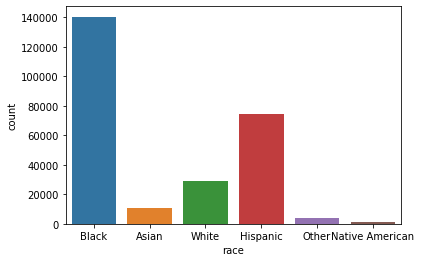

In [9]:
sns.countplot(x="race", data=df)

Text(0.5, 1.0, 'Proportion of race who get frisked')

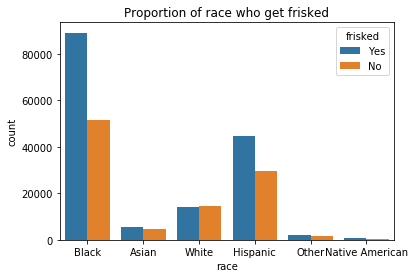

In [10]:
sns.countplot(x="race", hue="frisked", data=df)
plt.title('Proportion of race who get frisked')

In [11]:
## Keep only Whites and Blacks 
df = df[(df['race'] == 'Black') | (df['race'] == 'White')]

##  Encoding  

In [12]:
### Encoding YES or NO
le = LabelEncoder()
#convert the categorical columns into numeric

df['sex'] = le.fit_transform(df['sex']) # 1 -> Male, 2 -> Male
df['race'] = le.fit_transform(df['race']) # Black -> 0, White -> 1
df['inout'] = le.fit_transform(df['inout'])
df = df.replace({'Yes':1, "No": 0})

df['perobs'] = df['perobs'].astype('float')
df['perstop'] = df['perstop'].astype('float')
df['age'] = df['age'].astype('int')

In [13]:
df.head()

,age,sex,race,perobs,perstop,explnstp,sumissue,inout,rf_attir,searched,frisked,offunif,pistol,contrabn,arstmade
0,41,1,0,6.0,1.0,1,0,0,1,0,1,0,0,0,0
2,20,1,0,10.0,5.0,1,0,0,0,1,1,0,0,0,0
3,57,1,0,1.0,1.0,1,0,1,0,0,0,1,0,0,0
4,31,1,0,5.0,2.0,1,0,1,0,0,0,1,0,0,0
5,57,1,1,1.0,1.0,1,0,1,0,0,0,1,0,0,0


In [14]:
df.shape

(169217, 15)

## ML Models Before Mitigating Bias 

In [15]:
X = df.copy()
y = df['frisked']
X = X.drop(['arstmade','frisked'], axis=1)

In [16]:
X.head()

,age,sex,race,perobs,perstop,explnstp,sumissue,inout,rf_attir,searched,offunif,pistol,contrabn
0,41,1,0,6.0,1.0,1,0,0,1,0,0,0,0
2,20,1,0,10.0,5.0,1,0,0,0,1,0,0,0
3,57,1,0,1.0,1.0,1,0,1,0,0,1,0,0
4,31,1,0,5.0,2.0,1,0,1,0,0,1,0,0
5,57,1,1,1.0,1.0,1,0,1,0,0,1,0,0


In [17]:
print(X.shape)
print(y.shape)

(169217, 13)
(169217,)


In [18]:
#### Split the dataset ####

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(118451, 13)
(50766, 13)
(118451,)
(50766,)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.690875783004373
Precision: 0.7053845537787982
Recall: 0.8501608751608751
[[ 8650 11036]
 [ 4657 26423]]


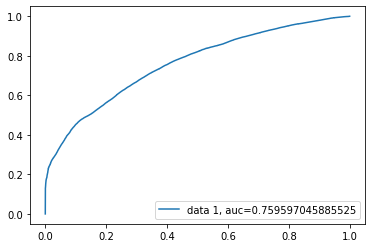

In [19]:
## Logistic Regression 
# https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

lg = LogisticRegression()

lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)

y_pred_proba = lg.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Measure Bias 

In [30]:
X_test['actual'] = y_test
X_test['predicted'] = y_pred

white_test = X_test[X_test['race'] == 1]
black_test = X_test[X_test['race'] == 0]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
print("For White People")
tn, fp, fn, tp  = metrics.confusion_matrix(white_test['actual'], white_test['predicted']).ravel() 
print("Preicsion", tp / (tp + fp))
print("Recall",tp / (tp + fn))

For White People
Preicsion 0.7017861765467254
Recall 0.6380324782301718


In [35]:
print("For Black People")
tn, fp, fn, tp  = metrics.confusion_matrix(black_test['actual'], black_test['predicted']).ravel() 
print("Preicsion", tp / (tp + fp))
print("Recall",tp / (tp + fn))

For Black People
Preicsion 0.7057983093225384
Recall 0.8837538667958704
